# 1.  超市销售额预测背景

  销售额预测是指对未来特定时间内全部产品或特定产品的销售数量与销售金额的估计，其本质是在充分考虑未来各种影响因素的基础上结合本企业的销售实绩，通过一定分析方法提出切实可行的销售目标。 我们将在本案例中，通过超市往年的销售额数据预测之后的超市销售额。
实验结果：
 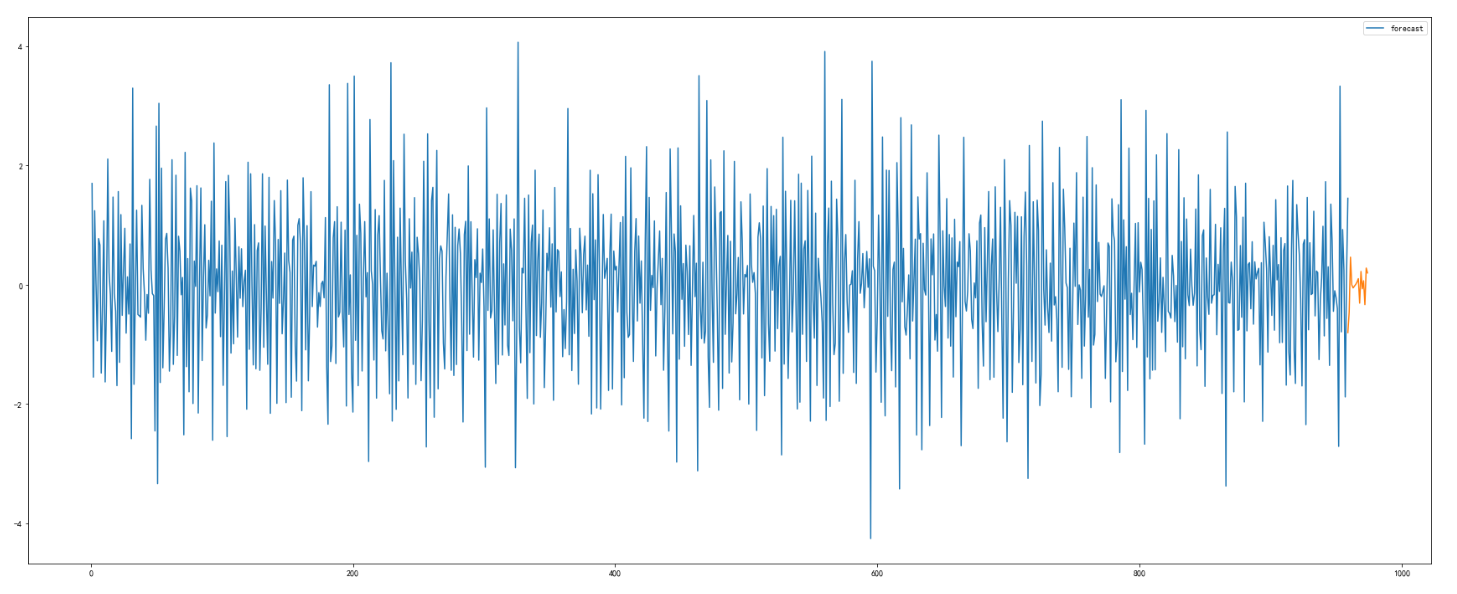

# 2.  超市销售额预测项目实现
项目主要分为三个阶段：  
   1. 数据预处理：主要内容是进行数据整合、数据清洗
  
   2. 数据可视化：对整合后的数据可视化可以直观地了解各变量之间的关系
      
   3. 预测分析：通过1、2的分析搭建时间序列模型并进行预测分析

### 工具包准备

In [1]:
#首先导入需要的工具包并且导入数据
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller #用于时间序列平稳性检测的库包
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
#from fbprophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX # 用于搭建时间序列分析模型：SARIMAX模型的库包

In [2]:
import warnings
warnings.filterwarnings("ignore")#解决警报出现问题
plt.rcParams['font.sans-serif'] = ['SimHei']   #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决中文显示问题

## 2.1  数据预处理
主要包括：

   * 数据整合：数据导入、数据查看
   
   * 数据清洗：列名规范化、数据类型处理、重复值处理、缺失值处理、异常值处理等内容

## 2.1.1  数据整合
内容包括：           
 1. 数据导入      
 2. 数据查看

#### (1) 数据导入

In [3]:
data = pd.read_csv('./supermarket_sales - Sheet1.csv')
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


#### (2) 数据查看
    

In [4]:
#查看数据集大小
data.shape

(1000, 17)

In [5]:
#再查看一下数据的概况
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

## 2.1.2  数据清洗
内容包括：  
   （1）数据类型处理；  
   （2）重复值处理；  
   （3）缺失值处理；  
   （4）异常值处理。

#### (1) 数据类型处理

In [6]:
#查看数据类型
data.dtypes

Invoice ID                  object
Branch                      object
City                        object
Customer type               object
Gender                      object
Product line                object
Unit price                 float64
Quantity                     int64
Tax 5%                     float64
Total                      float64
Date                        object
Time                        object
Payment                     object
cogs                       float64
gross margin percentage    float64
gross income               float64
Rating                     float64
dtype: object


可以看到：大部分列是object类型，销量、销售额、利润等列是数值型，这些列都不需要进行数据类型处理

In [7]:
#查看每一列的数据类型，并统计每一列有多少条信息
print(data['Branch'].value_counts())
print('-----------------------------------------------------------------')
print(data['Customer type'].value_counts())
print('------------------------------------------------------------------')
print(data['Gender'].value_counts())
print('-----------------------------------------------------------------')
print(data['Product line'].value_counts())
print('------------------------------------------------------------------')
print(data['Payment'].value_counts())
print('-----------------------------------------------------------------')

A    340
B    332
C    328
Name: Branch, dtype: int64
-----------------------------------------------------------------
Member    501
Normal    499
Name: Customer type, dtype: int64
------------------------------------------------------------------
Female    501
Male      499
Name: Gender, dtype: int64
-----------------------------------------------------------------
Fashion accessories       178
Food and beverages        174
Electronic accessories    170
Sports and travel         166
Home and lifestyle        160
Health and beauty         152
Name: Product line, dtype: int64
------------------------------------------------------------------
Ewallet        345
Cash           344
Credit card    311
Name: Payment, dtype: int64
-----------------------------------------------------------------


#### (2) 重复值处理

In [8]:
#判断数据是否有重复值
data.duplicated().sum()


0

In [9]:
#如需查找特定列则如下
data[data['Invoice ID'].duplicated()]

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating


#### (3) 缺失值处理

In [10]:
# 判断是否有数据缺失
data.isnull().sum(axis=0)

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

通过观察发现无缺失信息，如果有一列信息缺的很多，但它对我们的后续分析没有帮助则也可忽视

#### (4) 异常值处理

In [11]:
 #异常值处理
data.describe()#该方法返回DataFrame的统计变量

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905e+00,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,6.220360e-14,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905e+00,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905e+00,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905e+00,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905e+00,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905e+00,49.650000,10.00000


物理意义在于观察这一系列数据的范围，如：大小、波动趋势等等，便于判断后续对数据采取哪类模型更合适，是数据清理中经常用到的方法

In [12]:
#挑选出数据结构中 数据类型为浮点型和整型的列
data.select_dtypes(['float64', 'int64']).columns  

Index(['Unit price', 'Quantity', 'Tax 5%', 'Total', 'cogs',
       'gross margin percentage', 'gross income', 'Rating'],
      dtype='object')

## 2.2  数据可视化
该部分主要讲解如何绘制：           
（1）直方图和箱型图             
（2）多变量图           
（3）热点图           
（4）透视表           
（5）小提琴图 进行数据可视化分析数据。数据可视化的直接作用是： 1、更精准地认知数据内容；2、直观方式提供数据结果结果；3、帮助更快速地理解数据和数据之间直接关系

### (1) 直方图和箱型图
   ####                                            商品单价单价分析

(array([17., 17., 20., 21., 20., 17., 32., 18., 25., 21., 16., 11., 21.,
        24., 19., 19., 23., 12., 21., 19., 24., 20., 16., 27., 18., 21.,
        19., 16., 17., 17., 18., 19., 17., 13., 28., 31., 19., 24., 13.,
        22., 21., 10., 17., 24., 19., 14., 23., 18., 24., 38.]),
 array([10.08  , 11.8776, 13.6752, 15.4728, 17.2704, 19.068 , 20.8656,
        22.6632, 24.4608, 26.2584, 28.056 , 29.8536, 31.6512, 33.4488,
        35.2464, 37.044 , 38.8416, 40.6392, 42.4368, 44.2344, 46.032 ,
        47.8296, 49.6272, 51.4248, 53.2224, 55.02  , 56.8176, 58.6152,
        60.4128, 62.2104, 64.008 , 65.8056, 67.6032, 69.4008, 71.1984,
        72.996 , 74.7936, 76.5912, 78.3888, 80.1864, 81.984 , 83.7816,
        85.5792, 87.3768, 89.1744, 90.972 , 92.7696, 94.5672, 96.3648,
        98.1624, 99.96  ]),
 <BarContainer object of 50 artists>)

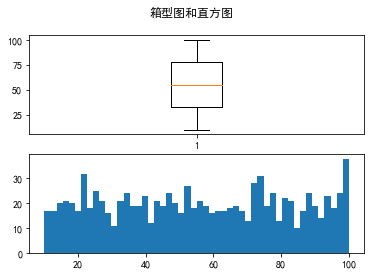

In [13]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('箱型图和直方图')#绘制总标题
ax1.boxplot(data['Unit price'])#Unit price单价
#bins=50 表示绘制直方图的时候显示50个柱状体
ax2.hist(data['Unit price'], bins= 50) 

箱型图中的五条关键线，从上到下依次为，上限值(也称上猫须)、上四分位（Q3），中位数(Q2)、下四分位(Q1)、下限值（也称下猫须）
Q1/Q2/Q3好理解，大概意思就是一组数值排序后，1/4位置的数、 1/2位置的数以及3/4位置的数

    IQR = Q3 -Q1 
    
    观察最大值： Q3+1.5*IQR  

    观察最小值 ：Q1-1.5*IQR 

    上猫须的值 = min(观察最大值，实际最大值)

    下猫须的值 = max（观察最小值，实际最小值） 

    所以有时候，猫须是最大最小值，有时候是观察最大最小值


#### 商品数量分析

(array([112.,  91.,  90., 109., 102.,  98., 102.,  85.,  92., 119.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

<Figure size 720x720 with 0 Axes>

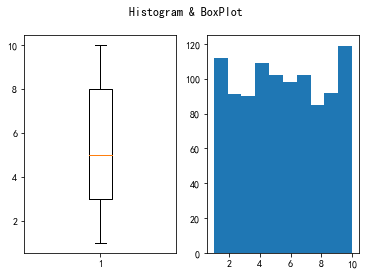

In [14]:
plt.figure(figsize=(10, 10))#定义图片大小
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Histogram & BoxPlot')#图片总标题
ax1.boxplot(data['Quantity'])#数量总量的箱型图
ax2.hist(data['Quantity'])#直方图

#### 商品税率数据分析

(array([233., 215., 146., 110.,  91.,  68.,  45.,  51.,  25.,  16.]),
 array([ 0.5085 ,  5.42265, 10.3368 , 15.25095, 20.1651 , 25.07925,
        29.9934 , 34.90755, 39.8217 , 44.73585, 49.65   ]),
 <BarContainer object of 10 artists>)

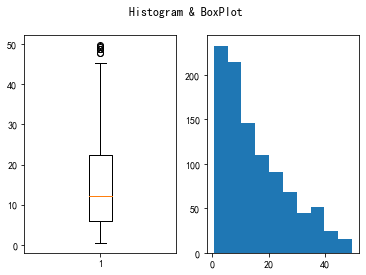

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Histogram & BoxPlot')
ax1.boxplot(data['Tax 5%'])#税率的箱型图
ax2.hist(data['Tax 5%'])#绘制直方图

此时超出猫须的点，我们认为是异常点

#### 商品总量分析

(array([233., 215., 146., 110.,  91.,  68.,  45.,  51.,  25.,  16.]),
 array([  10.6785 ,  113.87565,  217.0728 ,  320.26995,  423.4671 ,
         526.66425,  629.8614 ,  733.05855,  836.2557 ,  939.45285,
        1042.65   ]),
 <BarContainer object of 10 artists>)

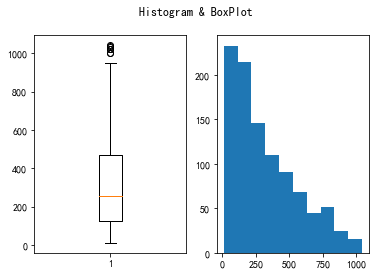

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Histogram & BoxPlot')#图片总标题
ax1.boxplot(data['Total'])
ax2.hist(data['Total'])

(array([233., 215., 146., 110.,  91.,  68.,  45.,  51.,  25.,  16.]),
 array([ 10.17 , 108.453, 206.736, 305.019, 403.302, 501.585, 599.868,
        698.151, 796.434, 894.717, 993.   ]),
 <BarContainer object of 10 artists>)

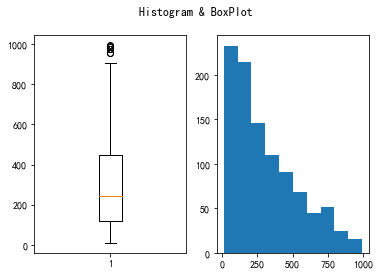

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Histogram & BoxPlot')
ax1.boxplot(data['cogs'])
ax2.hist(data['cogs'])

#### 比率分析

(array([28., 22., 18., 17., 17., 20., 13., 18., 21., 21., 26., 14., 19.,
        16., 14., 31., 26., 14., 21., 15., 37., 24., 19., 13., 15., 36.,
        18., 18., 16., 13., 38., 15., 18., 21., 13., 25., 18., 18., 18.,
        20., 30., 15., 14., 16., 16., 34., 17., 14., 19., 21.]),
 array([ 4.  ,  4.12,  4.24,  4.36,  4.48,  4.6 ,  4.72,  4.84,  4.96,
         5.08,  5.2 ,  5.32,  5.44,  5.56,  5.68,  5.8 ,  5.92,  6.04,
         6.16,  6.28,  6.4 ,  6.52,  6.64,  6.76,  6.88,  7.  ,  7.12,
         7.24,  7.36,  7.48,  7.6 ,  7.72,  7.84,  7.96,  8.08,  8.2 ,
         8.32,  8.44,  8.56,  8.68,  8.8 ,  8.92,  9.04,  9.16,  9.28,
         9.4 ,  9.52,  9.64,  9.76,  9.88, 10.  ]),
 <BarContainer object of 50 artists>)

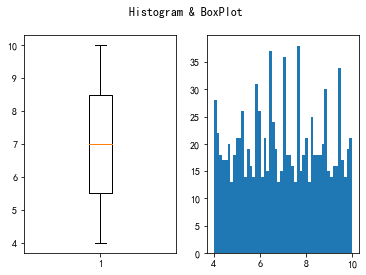

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Histogram & BoxPlot')
ax1.boxplot(data['Rating'])
ax2.hist(data['Rating'], bins=50)

#### 销售成本分析

<AxesSubplot:ylabel='Frequency'>

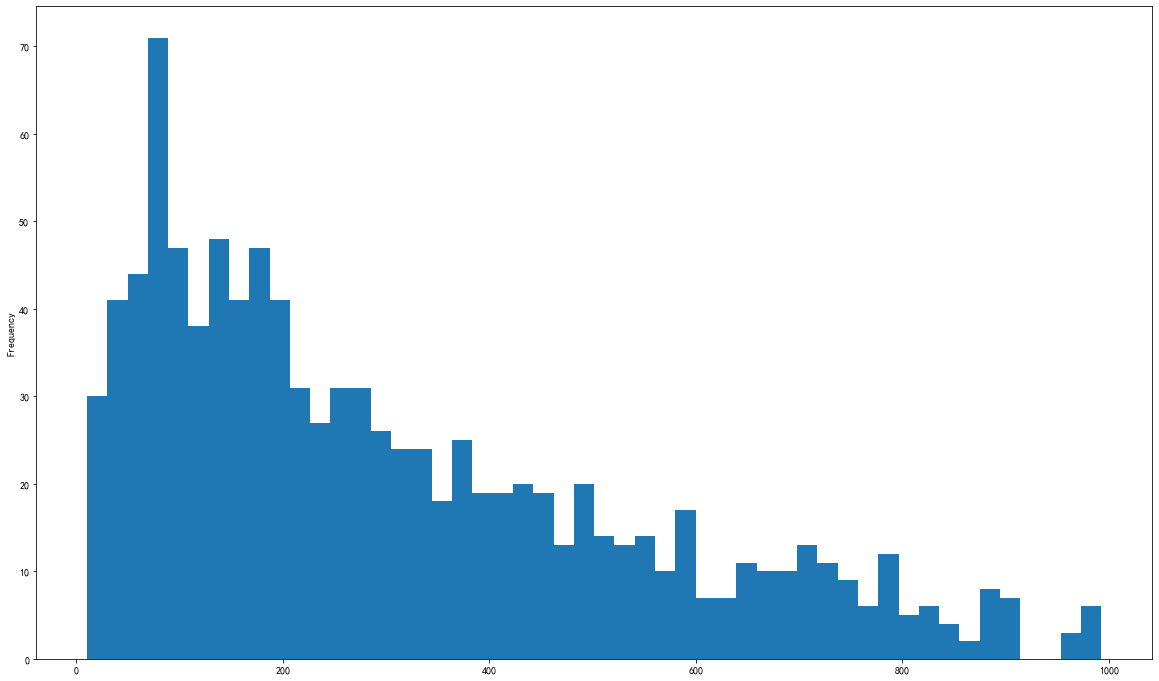

In [19]:
plt.figure(figsize=(20, 12))
data['cogs'].plot(kind='hist', bins=50) #cogs 销售成本

#### 通过数据可视化直观的了解数据内容后，对发现的异常和问题数据进行数据再清洗，如下：

In [20]:
index_cogs = data[data['cogs'] > 3 * data['cogs'].std() + 100 ].index
data_clean = data.drop(index_cogs, axis=0)
#DataFrame.drop(labels=None,axis=0, index=None, columns=None, inplace=False)
#axis=0，指删除index（行），axis=1，指删除columns（列）
#drop语句将表该列所占用的空间全释放掉

<AxesSubplot:>

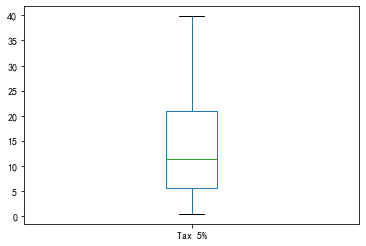

In [21]:
data_clean['Tax 5%'].plot(kind='box')

In [22]:
data_clean.describe().T#重新对清洗后的数据集进行描述

,count,mean,std,min,25%,50%,75%,max
Unit price,960.0,54.156146,2.592464e+01,10.080000,31.885000,53.255000,75.410000,99.960000
Quantity,960.0,5.337500,2.854601e+00,1.000000,3.000000,5.000000,8.000000,10.000000
Tax 5%,960.0,14.172479,1.029716e+01,0.508500,5.654250,11.404500,21.029250,39.824000
Total,960.0,297.622052,2.162405e+02,10.678500,118.739250,239.494500,441.614250,836.304000
cogs,960.0,283.449573,2.059433e+02,10.170000,113.085000,228.090000,420.585000,796.480000
gross margin percentage,960.0,4.761905,6.131625e-14,4.761905,4.761905,4.761905,4.761905,4.761905
gross income,960.0,14.172479,1.029716e+01,0.508500,5.654250,11.404500,21.029250,39.824000
Rating,960.0,6.976458,1.715016e+00,4.000000,5.500000,7.000000,8.500000,10.000000


### (2) 多变量图

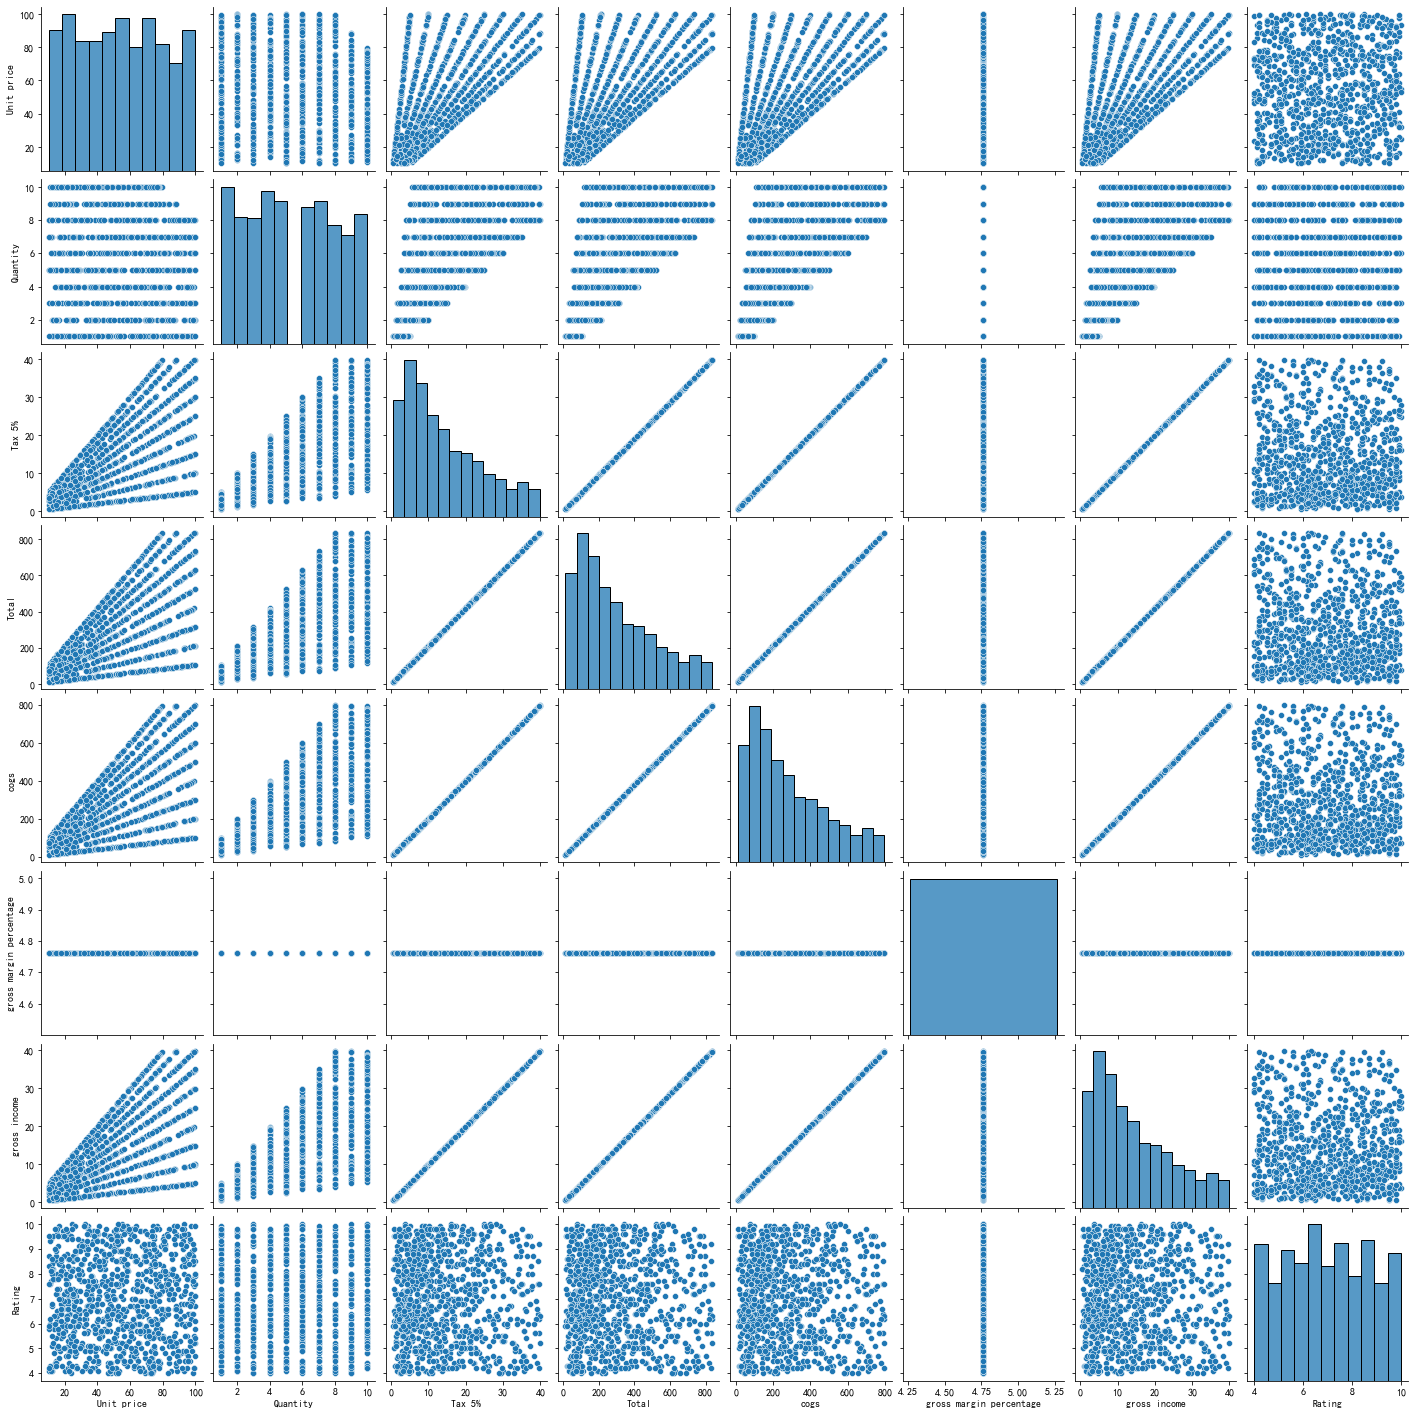

In [23]:
sns.pairplot(data_clean)#pairplot绘制多变量图
# 该函数会创建一个坐标轴矩阵，并且显示DataFrame对象中每对变量对的关系。另外，pairplot()函数也可以绘制每个变量在对角轴上的单变量分布

pairplot函数可视化可以用于探索数据特征间的关系

### (3) 热点图

<AxesSubplot:>

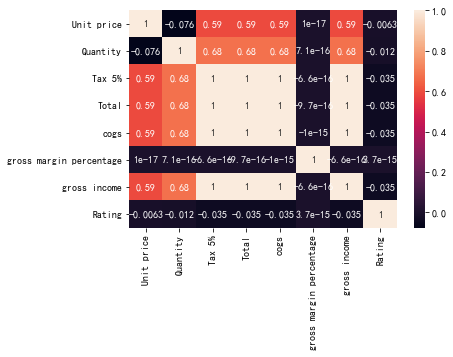

In [24]:
sns.heatmap(data_clean.corr(), annot=True) #绘制热点图
#seaborn.heatmap(data：数据, vmin：最小值, vmax：最大值，annot：设定是否显示数值）

上面是热图，通过热图可以简单地聚合大量数据，可以很直观地展现空间数据的疏密程度或频率高低。

但也由于太过直观，热图并不能完全保证数据表现的准确性。

### (4) 透视表

In [25]:
#将列数据设定为行索引和列索引，并可以聚合运算，pivot_table（）绘制数据透视表
#pivot_table（data：数据，values：被计算的数据项，index：行，cloumns：列，aggfunc:函数列表）
which_city_sale = data_clean.pivot_table(index = 'City', columns = 'Product line', values = 'cogs', aggfunc = 'sum')#sum指 选取了函数列表中选择了求和函数
# Product line：生产线；cogs：销售成本
which_city_sale

Product line,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel
City,,,,,,
Mandalay,15341.90,14799.23,13644.07,16449.72,14765.99,17324.22
Naypyitaw,16422.59,16843.62,17262.03,13253.52,11303.06,11450.13
Yangon,16558.17,14564.97,14645.77,11997.86,18794.68,16690.06


使用 pivot_table前你需要确保已理解了你的数据，并清楚地知道想通过透视表解决什么问题

虽然 pivot_table看起来只是一个简单的函数，但是它能够快速地对数据进行强大的分析

### (5) 小提琴图

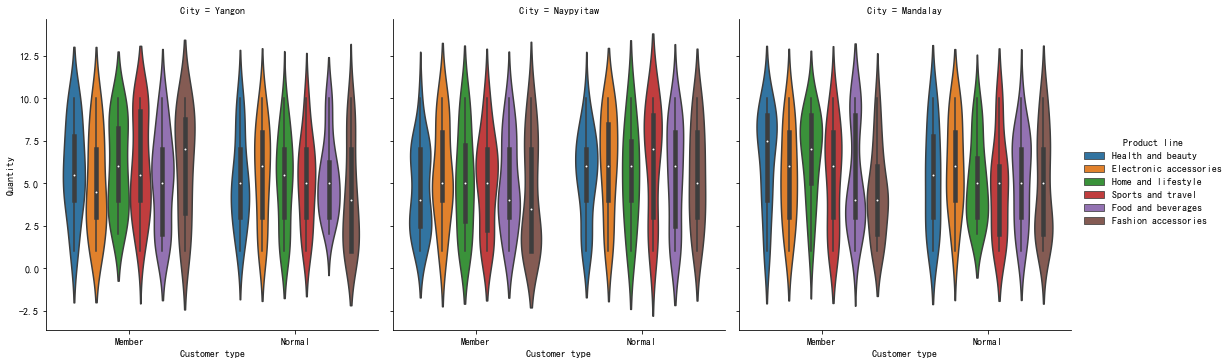

In [26]:
#生产线的小提琴图
sns.factorplot(x = 'Customer type', y = 'Quantity', hue='Product line', col = 'City', data=data_clean, kind='violin')
#seaborn.factorplot(x=None, y=None, hue=None, data=None, row：确定网格, col：kind:选择绘制图形类型）

In [27]:
data_clean['month'] = pd.DatetimeIndex(data_clean['Date']).month
plt.figure(figsize=(20, 12))

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

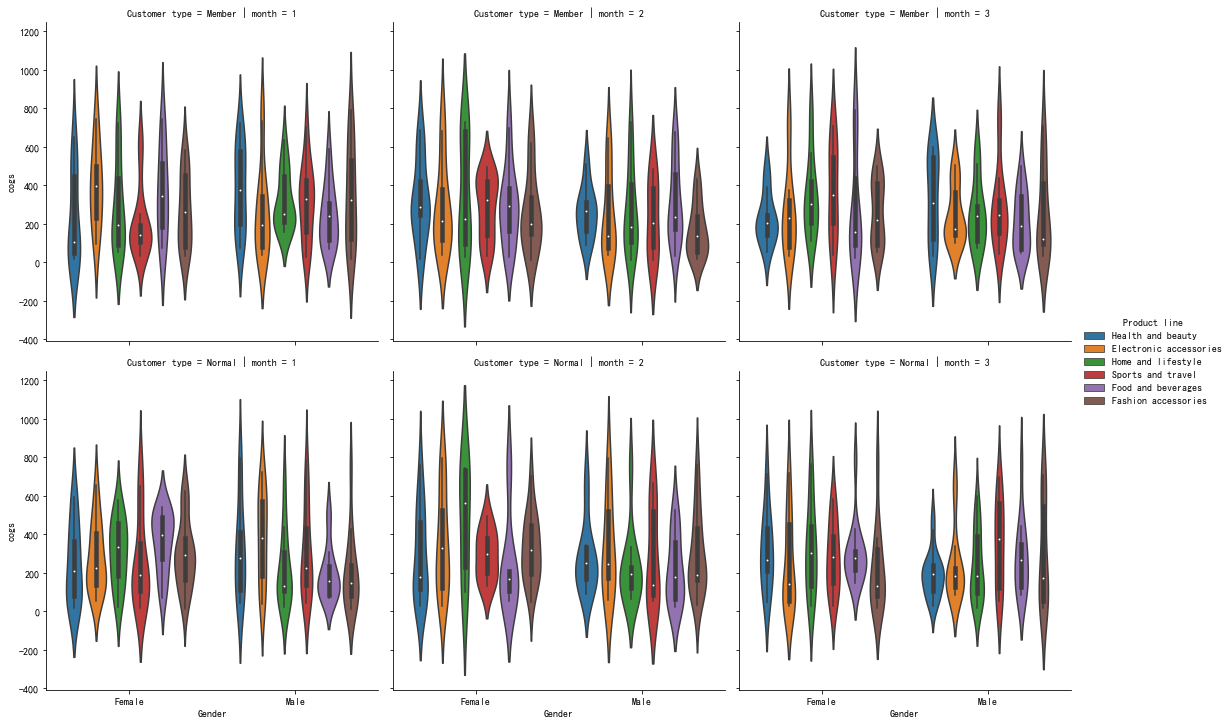

In [28]:
#消费者类型小提琴图
sns.factorplot(x = 'Gender', y = 'cogs', hue = 'Product line', col = 'month', kind='violin',row = 'Customer type' ,data = data_clean)
#Gender：性别；cogs：销售成本；Customer tpye：消费者类型

#### 通过更为直观的了解数据后，再一次对数据集进行排序操作

In [29]:
data_clean = data_clean.sort_values(by='Date').reset_index(drop=True)#sort_values(by='Date') 对列数据进行排序
data_clean

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating,month
0,182-52-7000,A,Yangon,Member,Female,Sports and travel,27.04,4,5.408,113.568,1/1/2019,20:26,Ewallet,108.16,4.761905,5.408,6.9,1
1,651-88-7328,A,Yangon,Normal,Female,Fashion accessories,65.74,9,29.583,621.243,1/1/2019,13:55,Cash,591.66,4.761905,29.583,7.7,1
2,133-14-7229,C,Naypyitaw,Normal,Male,Health and beauty,62.87,2,6.287,132.027,1/1/2019,11:43,Cash,125.74,4.761905,6.287,5.0,1
3,765-26-6951,A,Yangon,Normal,Male,Sports and travel,72.61,6,21.783,457.443,1/1/2019,10:39,Credit card,435.66,4.761905,21.783,6.9,1
4,891-01-7034,B,Mandalay,Normal,Female,Electronic accessories,74.71,6,22.413,470.673,1/1/2019,19:07,Cash,448.26,4.761905,22.413,6.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,308-47-4913,A,Yangon,Member,Female,Sports and travel,52.26,10,26.130,548.730,3/9/2019,12:45,Credit card,522.60,4.761905,26.130,6.2,3
956,616-87-0016,B,Mandalay,Normal,Male,Fashion accessories,95.54,7,33.439,702.219,3/9/2019,14:36,Credit card,668.78,4.761905,33.439,9.6,3
957,529-56-3974,B,Mandalay,Member,Male,Electronic accessories,25.51,4,5.102,107.142,3/9/2019,17:03,Cash,102.04,4.761905,5.102,6.8,3
958,816-57-2053,A,Yangon,Normal,Male,Sports and travel,60.87,2,6.087,127.827,3/9/2019,12:37,Ewallet,121.74,4.761905,6.087,8.7,3


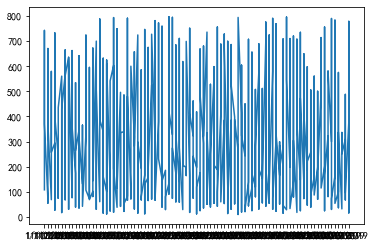

In [30]:
plt.plot(data_clean['Date'], data_clean['cogs'])#plot(X,Y):创建数据Y相对于中相应值X的二维折线图 这里是日期和销售成本的关系

## 2.3 预测分析
时间序列（或称动态数列）是指将同一统计指标的数值按其发生的时间先后顺序排列而成的数列。时间序列分析的主要目的是根据已有的历史数据对未来进行预测。经济数据中大多数以时间序列的形式给出。根据观察时间的不同，时间序列中的时间可以是年份、季度、月份或其他任何时间形式。

时间序列模型进行预测的基本流程 :      
（1）平稳性检测（ADF）及处理;          
（2）模型训练；     
（3）检验是否具有统计意义 ;  
（4）假设检验;  
（5）预测分析            

#### 2.3.1 平稳性检测（ADF）及处理
在使用很多时间序列模型的时候，都会要求时间序列是平稳的。平稳性是时间序列的内部逻辑性，也就是说每一期的序列值与前几期之间存在一种一致的结构性变化关系，即时间序列的行为并不随期数改变，只有序列是平稳的我们才能建立模型去分析并预测，根本原因在于统计学或者计量经济学是从数量规律的角度研究事情。则在使用时间序列模型进行预测的第一步都是序列平稳性检测


##### 2.3.1.1 平稳性检测
单位根（ADF）检验是假设检验的一种常用于判断序列是否平稳。  
如果序列平稳，就不存在单位根；否则序列不平稳，就会存在单位根。  
如果数据序列是非平稳的，并存在一定的增长或下降趋势，则需要对数据进行差分处理，  
如果数据存在异方差，则需对数据进行技术处理，直到处理后的数据的自相关函数值和偏相关函数值无显著地异于零。  

In [31]:
adfuller(data_clean['cogs'] )#adfuller()是ADF检验常用的函数，用于构建回归模型
#adfuller(x：要测试的数据护具系列, maxlag：测试中的最大延迟， regression='c', autolag='AIC', store=False, regresults=False)

(-31.315250449340063,
 0.0,
 0,
 959,
 {'1%': -3.43718721587049,
  '5%': -2.8645585177815187,
  '10%': -2.568377225331392},
 12643.753430368224)

In [32]:
data_clean['cogs']

0      108.16
1      591.66
2      125.74
3      435.66
4      448.26
        ...  
955    522.60
956    668.78
957    102.04
958    121.74
959    519.40
Name: cogs, Length: 960, dtype: float64

返回的重要参数内容为      
{      
    ADF：测试统计值，          
    usedlag；使用的滞后数量，      
    NOBS：用于ADF回归和计算临界值的观察数，      
    critical values：测试统计数据的临界统计值为1％，5％和10％，           
}      

ADF检验的假设就是存在单位根，如果得到的显著性检验统计量ADF测试统计值，小于三个置信度（1%，5%，10%），则对应有（99%，95，90%）的把握来拒绝存在单位根的原假设

本数据中，adf结果为-30.6， 远小于三个level的统计值。则该序列为一个平稳序列

##### 2.3.1.2 对平稳的时间序列进行数据预处理
对数据取log可以更清晰的排除增加量带来的影响，更清晰地看出数据变化的规律，

In [33]:
data_clean['cogs'] = np.log(data_clean['cogs'])#np.log（x）以e为底x为指数
adfuller(data_clean['cogs'])

(-23.458450851928866,
 0.0,
 1,
 958,
 {'1%': -3.4371943720994165,
  '5%': -2.8645616735407002,
  '10%': -2.568378906211183},
 2465.317257599291)

In [37]:
data_clean['cogs']


1      1.699321
2     -1.548716
3      1.242646
4      0.028511
5     -0.938761
         ...   
955    0.926871
956    0.246639
957   -1.880090
958    0.176523
959    1.450787
Name: cogs, Length: 959, dtype: float64

In [34]:

data_clean['cogs'] = data_clean['cogs'].diff()
data_clean = data_clean.drop(0, axis=0)
adfuller(data_clean['cogs'])

(-11.28246799429914,
 1.4448383623325856e-20,
 22,
 936,
 {'1%': -3.43735568849112,
  '5%': -2.864632808981867,
  '10%': -2.5684167960132225},
 2525.0337150538453)

通过以上的处理，就能非常直观地可视化时间和销售成本的关系

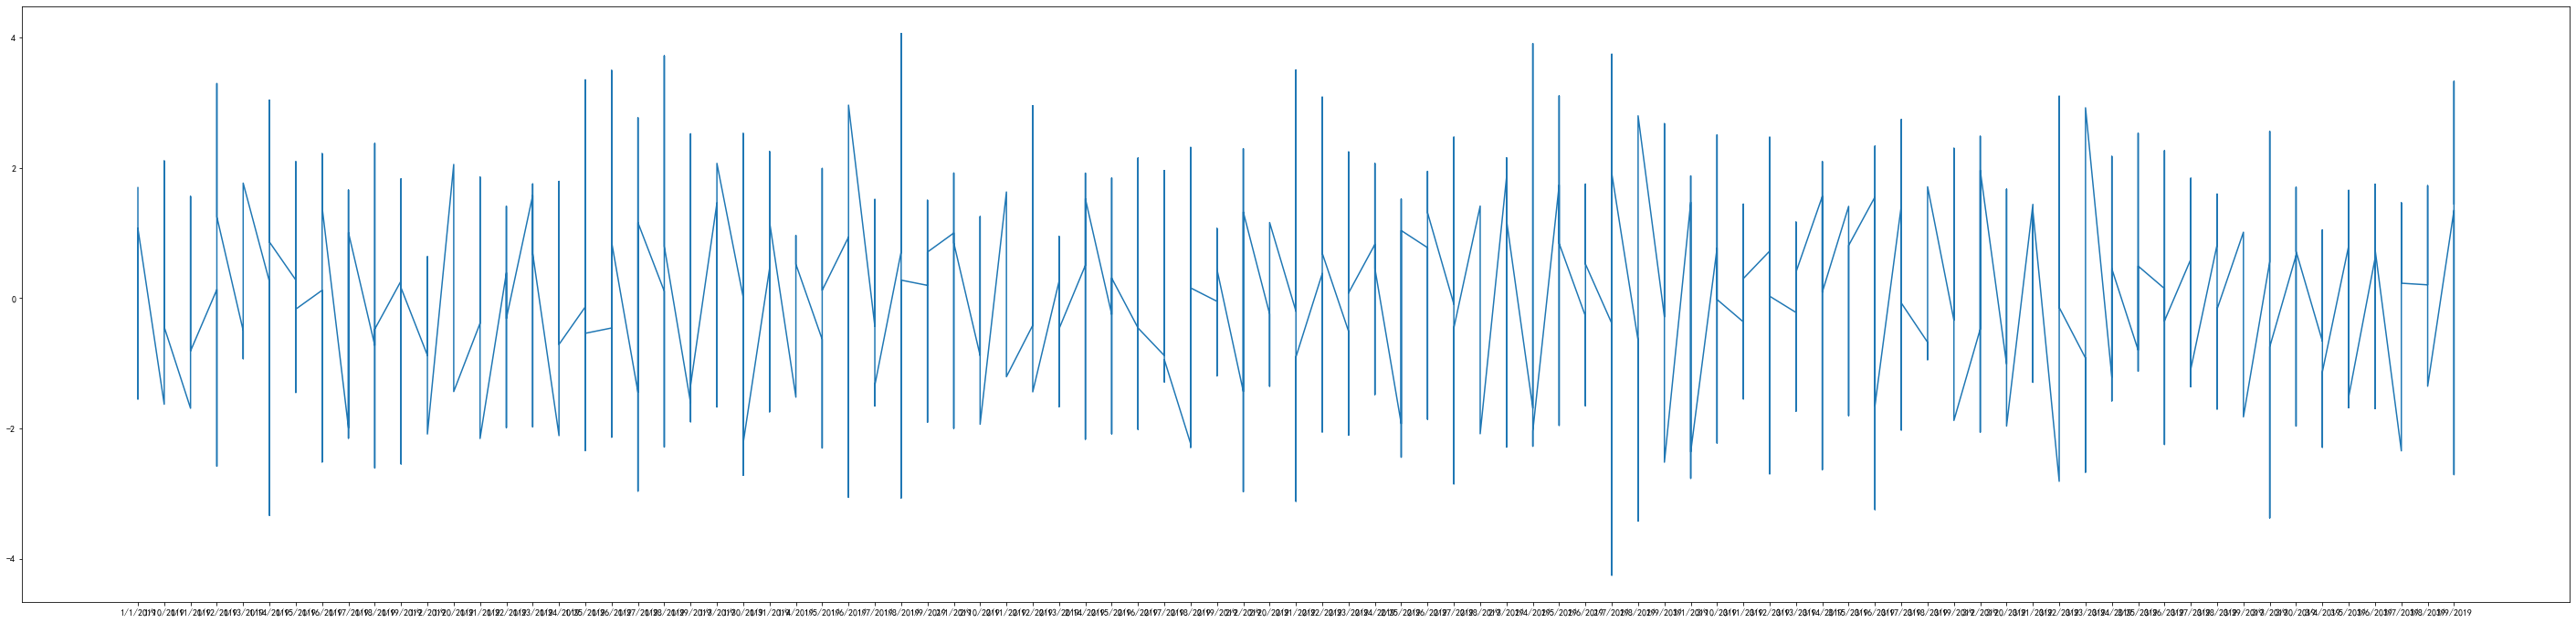

In [39]:
plt.figure(figsize=(50, 12))
plt.plot(data_clean['Date'].sort_values(), data_clean['cogs'])

#### 2.3.2 模型训练（建立模型+数据对比）
时间序列常用模型有自回归模型（AR）、移动平均模型（MA）、自回归移动平均模型（ARMA）、差分自回归移动平均模型（ARIMA）（具体参数参考https://blog.csdn.net/aipotong0564/article/details/101653727 ）

为了更好的预测销量数据，我们选择搭建在经典的时间序列模型-差分移动自回归模型（ARIMA）的基础上加上季节（S,Seasonal）和外部因素(X,eXogenous)的SARIMAX模型（具体参数参考https://blog.csdn.net/fitzgerald0/article/details/100823231 ）       
此次使用到三个关键数据：      
(1)endog（数据）：观察（自）变量 y      
(2)order：自回归，差分，滑动平均项 (p,d,q)   
那么如何使一序列稳定呢？  
最常见的方法是加以差分。即，从当前值中减去先前的值。  
因此，d的值是使序列*稳所需的最小差分数。如果时间序列已经固定，则d = 0。  
接下来，什么是“ p”和“ q”？  
“ p”是“自回归”（AR）术语的顺序。它指的是要用作预测变量的Y的滞后次数。而“ q”是“移动*均”（MA）项的顺序。它是指应输入ARIMA模型的滞后预测误差的数量。  
(3)seasonal_order：季节因素的自回归，差分，移动平均，周期 (P,D,Q,s)     


##### 2.3.2.1 建立模型

确定d

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

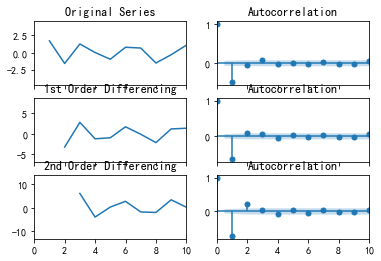

In [49]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data_clean['cogs']); axes[0, 0].set_title('Original Series')
axes[0,0].set(xlim=(0,10))
plot_acf(data_clean['cogs'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_clean['cogs'].diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1,0].set(xlim=(0,10))
plot_acf(data_clean['cogs'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_clean['cogs'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
axes[2,0].set(xlim=(0,10))
plot_acf(data_clean['cogs'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

确定AR项的阶数（p）

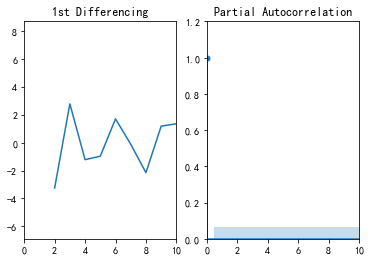

In [52]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data_clean['cogs'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2),xlim=(0,10))
plot_pacf(data_clean['cogs'].diff().dropna(), ax=axes[1])
plt.show()

确定MA项的阶数（q）

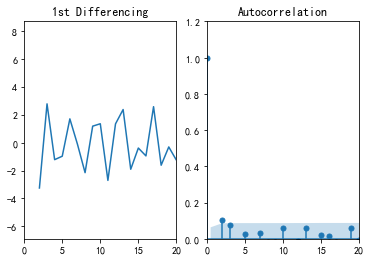

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data_clean['cogs'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2),xlim=(0,20))
plot_acf(data_clean['cogs'].diff().dropna(), ax=axes[1])
plt.show()

In [56]:
m  = SARIMAX(data_clean['cogs'], order = (3, 1, 3), seasonal_order=(3, 1, 3, 6))#cogs是主营业务成本

res = m.fit()#fit（）方法用训练器数据拟合分类器模型 （通过卡尔曼滤波对模型进行极大似然拟合）

通过基础方法 model.summary() 输出回归模型各层的参数

In [57]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              cogs   No. Observations:                  959
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 6)   Log Likelihood               -1279.377
Date:                           Wed, 21 Apr 2021   AIC                           2584.755
Time:                                   17:22:21   BIC                           2647.916
Sample:                                        0   HQIC                          2608.818
                                           - 959                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0287      0.044    -23.564      0.000      -1.114      -0.943
ar.L2         -0.0853      0.049     -1.730      0.084      -0.182       0.011
ar.L3         -0.0514      0.036     -1.421      0.155      -0.122       0.020
ma.L1         -0.9915      0.692     -1.432      0.152      -2.349       0.366
ma.L2         -0.9997      1.379     -0.725      0.468      -3.702       1.703
ma.L3          0.9914      0.687      1.444      0.149      -0.354       2.337
ar.S.L6       -1.8622      0.042    -44.812      0.000      -1.944      -1.781
ar.S.L12      -0.9753      0.072    -13.625      0.000      -1.116      -0.835
ar.S.L18       0.0092      0.036      0.260      0.795      -0.060       0.079
ma.S.L6        0.8604     71.001      0.012      0.990    -138.299     140.020
ma.S.L12      -0.8752    132.089     -0.007      0.995    -259.765     258.015
ma.S.L18      -0.9852     69.950     -0.014      0.989    -138.085     136.115
sigma2         0.8030     56.940      0.014      0.989    -110.798     112.404
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                53.74
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.58
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

训练完模型后，将模型拟合的数据以新的一列'arima_predict'存到数据集data_clean中

In [59]:
data_clean['sarima_predict'] = res.fittedvalues
data_clean['sarima_predict'] 

1      0.000000
2      1.699315
3     -1.548693
4      1.242623
5      0.028522
         ...   
955    0.064588
956   -0.843273
957   -1.191324
958    0.818778
959    0.568219
Name: sarima_predict, Length: 959, dtype: float64

##### 2.3.2.2 对拟合值和真实值作图进行对比


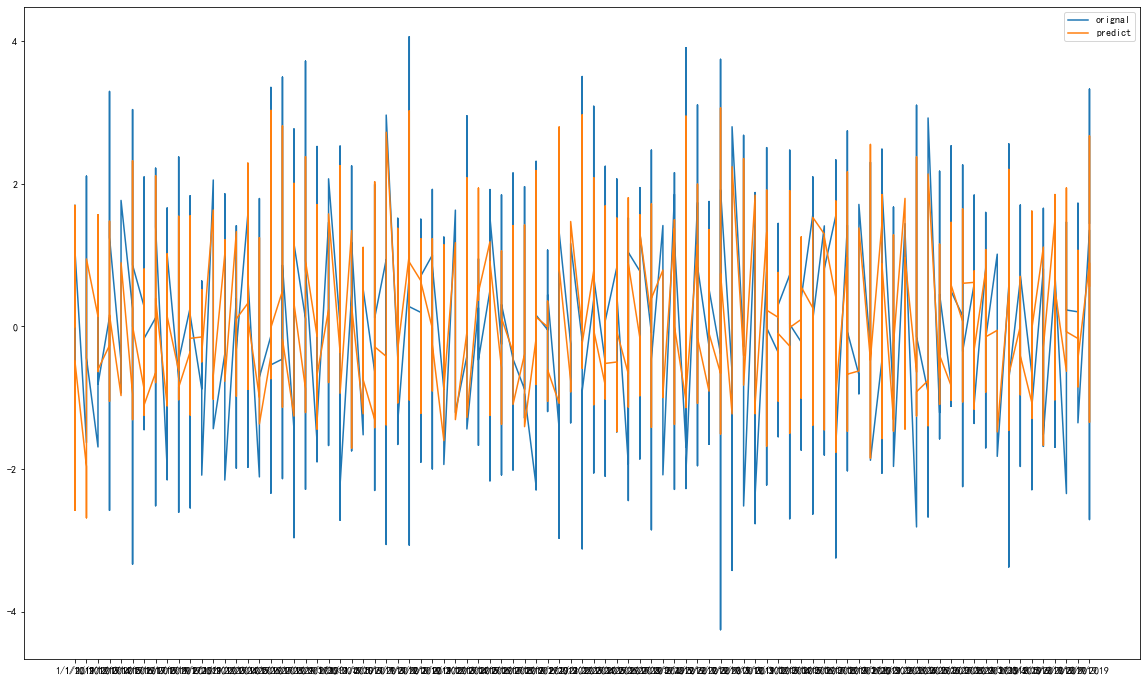

In [60]:
plt.figure(figsize=(20, 12))
plt.plot(data_clean['Date'].sort_values(), data_clean['cogs'],label='orignal')
plt.plot(data_clean['Date'].sort_values(), data_clean['sarima_predict'],label='predict')
plt.legend()

从时间序列图和预测精度来看，模型已经达到比较好的拟合效果

#### 2.3.3 预测分析
按照基础流程res模型拟合后，model.predict（）方法返回模型拟合的值

In [61]:
forecast = res.predict(start=len(data_clean), end=len(data_clean) + 15) #predict（）返回的是一个大小为n的一维数组，一维数组中的第i个值为模型预测第i个预测样本的标签

In [62]:
len(data_clean['arima_predict'])

959

In [63]:
data_clean['cogs'].append(forecast)

1      1.699321
2     -1.548716
3      1.242646
4      0.028511
5     -0.938761
         ...   
970   -0.063717
971    0.063853
972   -0.325755
973    0.275787
974    0.199653
Length: 975, dtype: float64

最后对通过时间序列预测得到的数据进行可视化操作，更直观地反馈预测信息

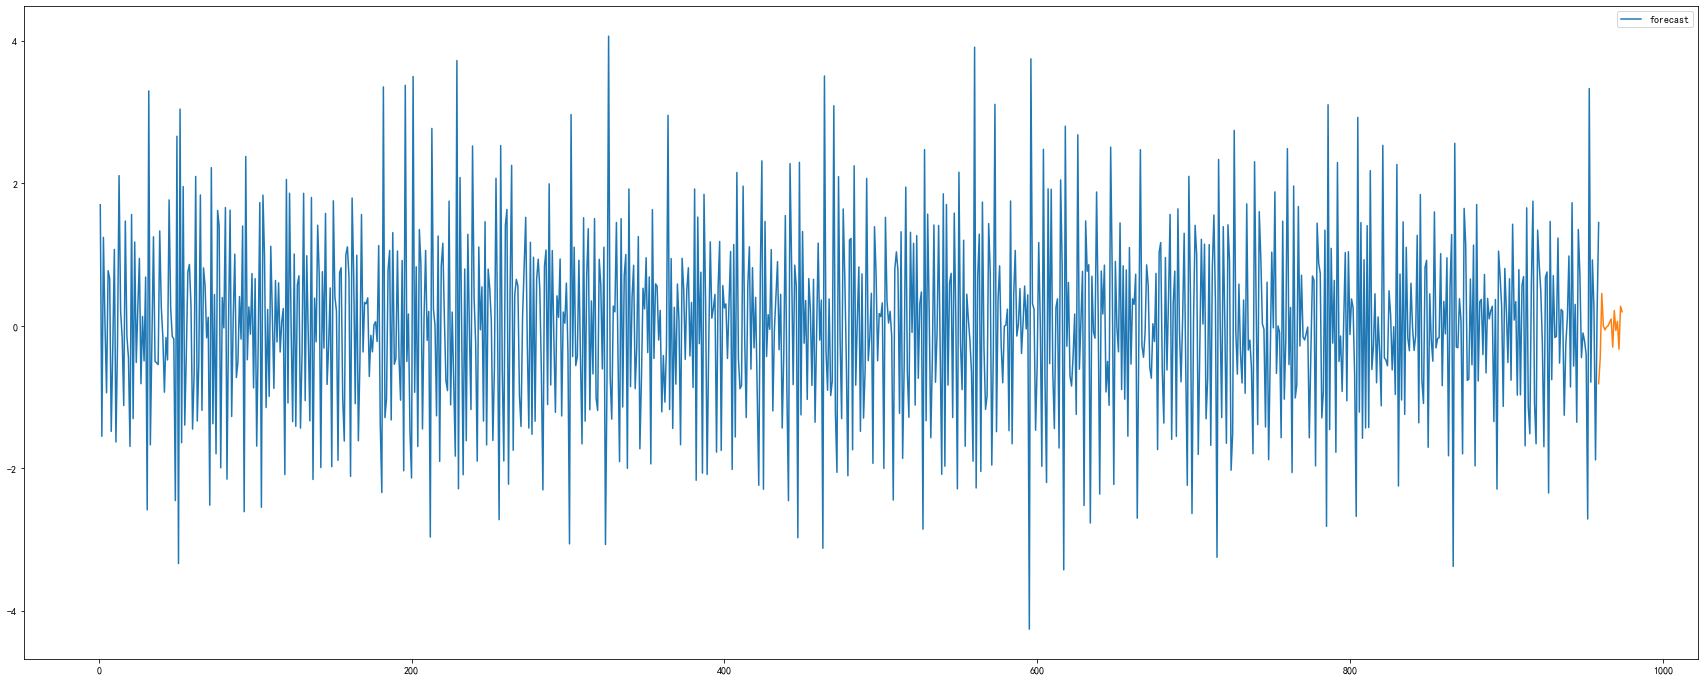

In [64]:
plt.figure(figsize=(30, 12))
plt.plot(data_clean['cogs'],label='forecast')
plt.plot(forecast)
plt.legend()